# Agent Metrics Analysis

This notebook processes and visualizes agent metrics from the monitor.csv file.

In [1]:
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import json
import os
import numpy as np

In [2]:
from __future__ import annotations

import glob
import os
import time
import csv

import supersuit as ss
from stable_baselines3 import PPO
from sb3_contrib import RecurrentPPO
from scipy import stats

import gymnasium as gym 

from pettingzoo.sisl import waterworld_v4, waterworld_model1

import matplotlib.pyplot as plt
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.evaluation import evaluate_policy
from pettingzoo.utils.conversions import aec_to_parallel
from stable_baselines3.common.callbacks import EvalCallback, StopTrainingOnNoModelImprovement, CheckpointCallback

import numpy as np 
import pandas as pd

from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.vec_env import DummyVecEnv, VecMonitor


## Set the log directory and process the data

In [30]:
# Set your log directory here
env_fn = waterworld_model1
env_kwargs = {"n_pursuers" : 2}


# Evaluate a trained agent vs a random agent
env = env_fn.env(render_mode=None, **env_kwargs)
log_dir = "/Users/idil/PettingZoo/SB3-training/logs/average_pettingzoo.sisl.waterworld_model1_20240819-135152/"
latest_policy = "/Users/idil/PettingZoo/SB3-training/logs/average_pettingzoo.sisl.waterworld_model1_20240819-135152/rl_model_640000_steps.zip"

model = RecurrentPPO.load(latest_policy)


In [31]:
obs = env.reset()

    # Cell and hidden state of the LSTM
lstm_states = None
num_envs = 1
    # Episode start signals are used to reset the lstm states
episode_starts = np.ones((num_envs,), dtype=bool)


In [46]:
print(f"Starting eval on {str(env.metadata['name'])}.")
# Initialize data structures to store step-wise information
all_data = {agent: {
        'rewards': [],
        'arousal': [],
        'satiety': [],
        'social_touch': [],
        'step': [],
        'episode': []
} for agent in env.possible_agents}
    # Note: We train using the Parallel API but evaluate using the AEC API
    # SB3 models are designed for single-agent settings, we get around this by using he same model for every agent
env.reset(seed=4300)

total_steps = 0
num_games = 10 
for episode in range(num_games):
    env.reset(seed=episode)
    print(f"Episode {episode}")
        
    episode_step = 0
    for agent in env.agent_iter():
        obs, reward, termination, truncation, info = env.last()
            
        for a in env.agents:
            all_data[a]['rewards'].append(env.rewards[a])
            all_data[a]['step'].append(total_steps)
            all_data[a]['episode'].append(episode)
                
            for metric in ['arousal', 'satiety', 'social_touch']:
                if metric in info:
                    agent_name = info[metric].split('_')[0] + "_" + info[metric].split('_')[1]
                    if a != agent_name:
                        print("DANGER")
                        print(a)
                        print(agent_name)
                    value = float(info[metric].split('_')[-1])
                    all_data[agent_name][metric].append(value)
                else:
                    all_data[a][metric].append(None)  # or some default value

        if termination or truncation:
            break
        else:
            act, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)
            
        env.step(act)
        episode_step += 1
        total_steps += 1

    env.close()


Starting eval on waterworld_model1.
Episode 0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_1
pursuer_0
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_0
pursuer_1
DANGER
pursuer_1
pursuer_0
DANGER
pu

In [ ]:
'''
for agent in env.agent_iter():
    obs, reward, termination, truncation, info = env.last()

    for a in env.agents:
        rewards[a] += env.rewards[a]
        print("reward for agent " + str(a) + " = " + str(rewards[a]))
                # Parse and store metrics
        for metric in ['arousal', 'satiety', 'social_touch']:
            if metric in info:
                value = float(info[metric].split('_')[-1])  # Extract the float value
                episode_metrics[a][metric].append(value)

    if termination or truncation:
        break
    else:
        act, lstm_states = model.predict(obs, state=lstm_states, episode_start=episode_starts, deterministic=True)

    env.step(act)
'''

In [49]:
# Convert to DataFrame for easier manipulation and plotting
df = pd.concat([pd.DataFrame(data) for data in all_data.values()], keys=all_data.keys())
df = df.reset_index(level=0).rename(columns={'level_0': 'agent'})

In [50]:
# Print overall evaluation results
print("\nOverall Evaluation Results:")
for agent in env.possible_agents:
    agent_data = df[df['agent'] == agent]
    print(f"Agent {agent}:")
    print(f"  Total Reward: {agent_data['rewards'].sum():.4f}")
    for metric in ['arousal', 'satiety', 'social_touch']:
        print(f"  {metric.capitalize()}: Mean = {agent_data[metric].mean():.4f}, Std = {agent_data[metric].std():.4f}")



Overall Evaluation Results:
Agent pursuer_0:
  Total Reward: 8170.2836
  Arousal: Mean = 0.5553, Std = 0.0796
  Satiety: Mean = 0.5536, Std = 0.5094
  Social_touch: Mean = nan, Std = nan
Agent pursuer_1:
  Total Reward: 12747.1209
  Arousal: Mean = 0.5446, Std = 0.0930
  Satiety: Mean = 0.7346, Std = 0.5528
  Social_touch: Mean = nan, Std = nan


PLOT RESULTS 

In [58]:
agent_data

,agent,rewards,arousal,satiety,social_touch,step,episode
0,pursuer_1,0.000000,NaN,NaN,None,0,0
1,pursuer_1,-0.000000,0.500000,0.500000,None,1,0
2,pursuer_1,1.446900,0.500000,0.500000,None,2,0
3,pursuer_1,-0.000000,0.500333,0.499000,None,3,0
4,pursuer_1,1.441686,0.500333,0.499000,None,4,0
...,...,...,...,...,...,...,...
10005,pursuer_1,5.953625,0.374840,1.350108,None,9996,9
10006,pursuer_1,-0.000000,0.374606,1.349192,None,9997,9
10007,pursuer_1,5.952641,0.374606,1.349192,None,9998,9
10008,pursuer_1,-0.000000,0.374373,1.348275,None,9999,9


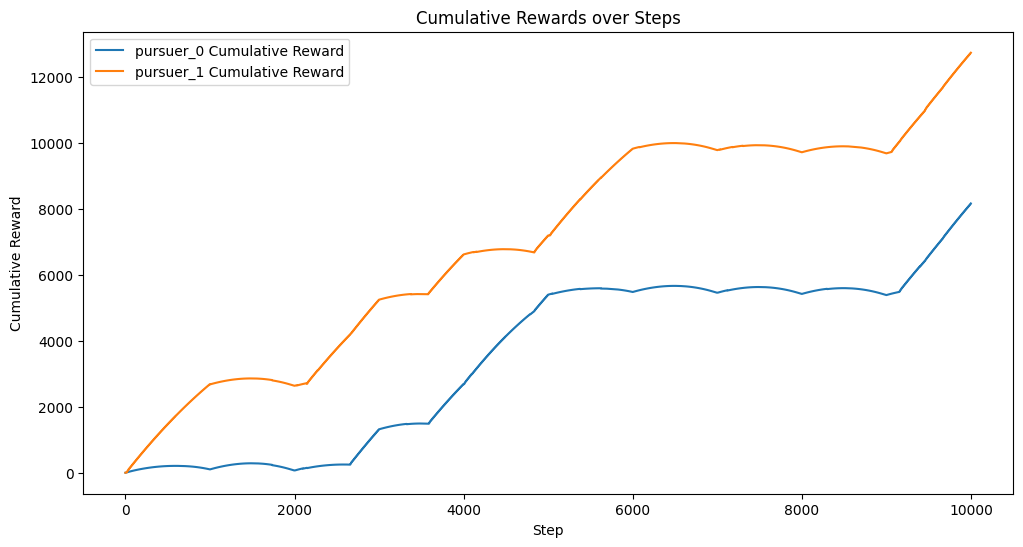

In [60]:
# Create a directory for plots if it doesn't exist
plot_dir = "/Users/idil/PettingZoo/SB3-training/logs/average_pettingzoo.sisl.waterworld_model1_20240819-135152/"
os.makedirs(plot_dir, exist_ok=True)

# Plot rewards
plt.figure(figsize=(12, 6))
for agent in df['agent'].unique():
    agent_data = df[df['agent'] == agent]
    plt.plot(agent_data['step'], agent_data['rewards'].cumsum(), label=f'{agent} Cumulative Reward')
plt.title('Cumulative Rewards over Steps')
plt.xlabel('Step')
plt.ylabel('Cumulative Reward')
plt.legend()



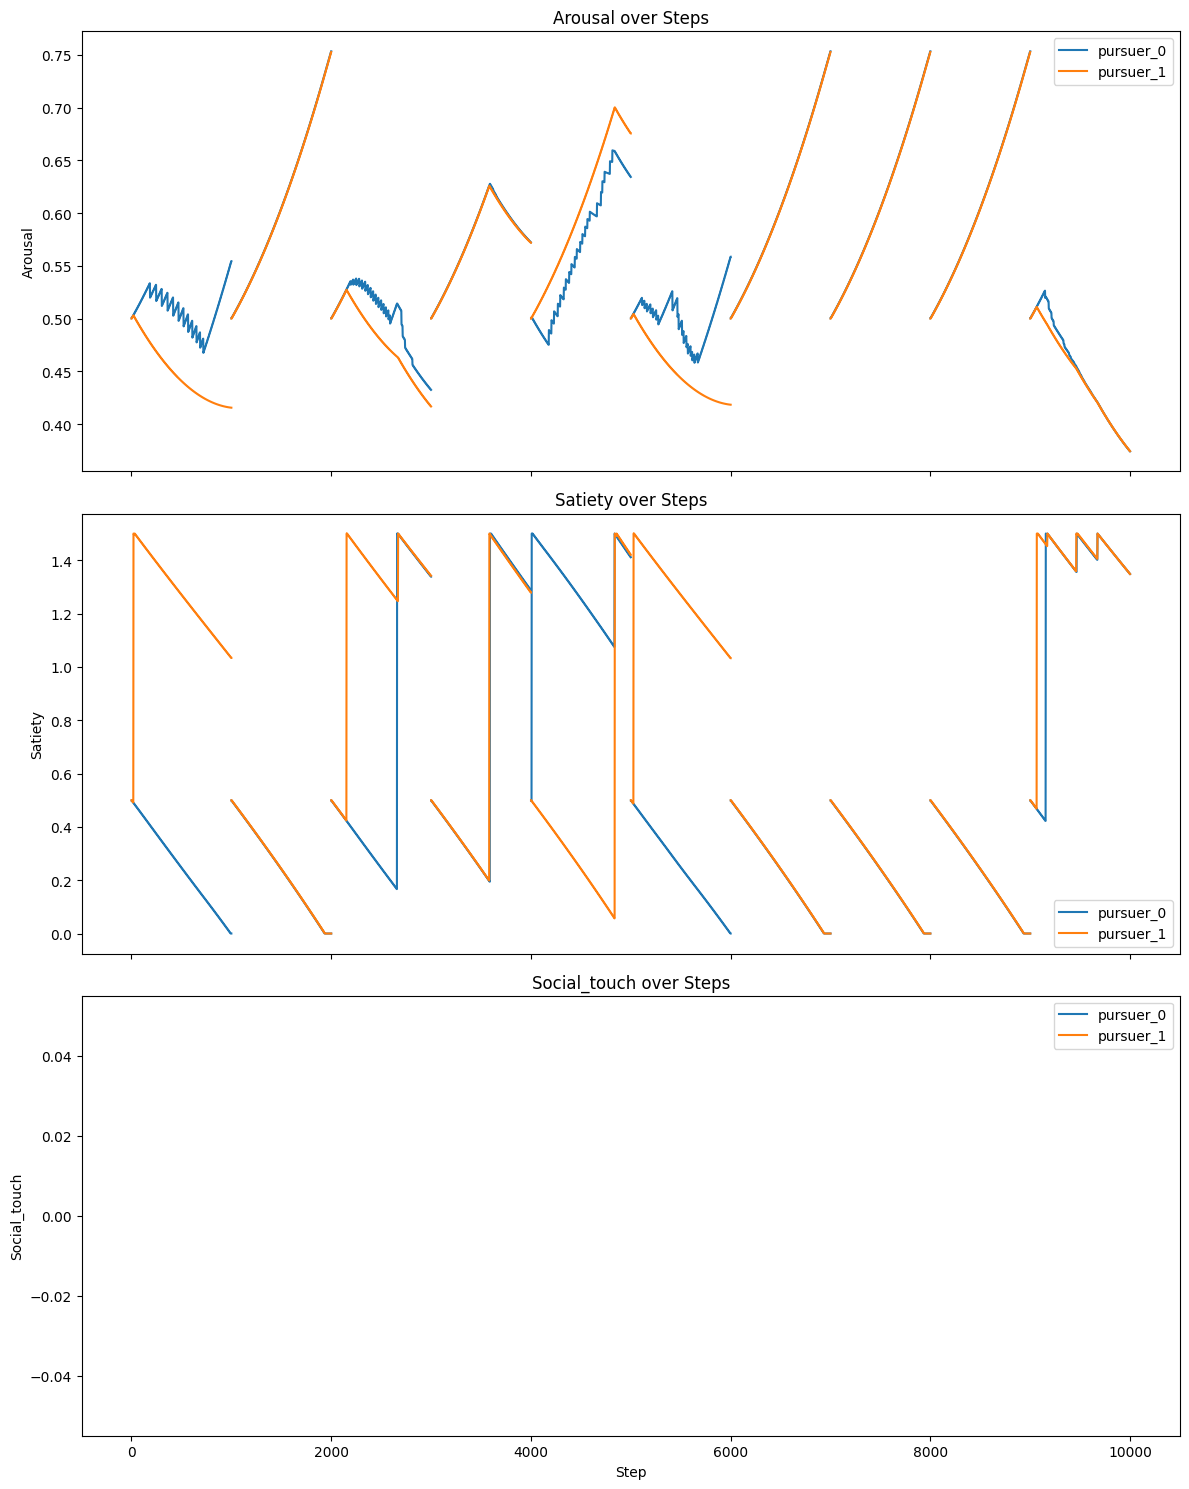

In [61]:

# Plot metrics
metrics = ['arousal', 'satiety', 'social_touch']
fig, axes = plt.subplots(len(metrics), 1, figsize=(12, 5*len(metrics)), sharex=True)
for i, metric in enumerate(metrics):
    for agent in df['agent'].unique():
        agent_data = df[df['agent'] == agent]
        axes[i].plot(agent_data['step'], agent_data[metric], label=agent)
    axes[i].set_title(f'{metric.capitalize()} over Steps')
    axes[i].set_ylabel(metric.capitalize())
    axes[i].legend()
axes[-1].set_xlabel('Step')
plt.tight_layout()
plt.savefig(f"{plot_dir}/metrics_over_steps.png")
    